# The Sed object

This example demonstrates the various methods associated with the `Sed` class.

`Sed` objects can be extracted directly from `Grid` objects or created by `Galaxy` objects. See tutorials on those objects for more information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from unyt import Angstrom, Hz, um, eV
from synthesizer.grid import Grid, get_available_lines
from synthesizer.sed import Sed
from synthesizer.filters import FilterCollection
from synthesizer.igm import Madau96

Let's begin by initialising a grid:

In [2]:
grid_dir = "../../tests/test_grid/"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)

Next, let's define a target log10age and metallicity and use the built-in `Grid` method to get the grid point and then extract the spectrum for that grid point.

In [3]:
log10age = 6.0  # log10(age/yr)
metallicity = 0.01
spectra_id = "incident"
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
sed.lnu *= 1e8  # make the SED bigger

Like other `synthesizer` objects, we get some basic information about the `Sed` object by using the `print` command:

In [4]:
print(sed)

----------
SUMMARY OF SED 
Number of wavelength points: 8228 
Wavelength range: [0.00 Å,             299293000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.49 
log10(Bolometric luminosity/erg/s):36.84609876080591----------


`Sed` objects contain a wavelength grid and luminosity in the `lam` and `lnu` attributes. Both come with units making them easy to convert:

In [5]:
print(sed.lam)
print(sed.lnu)

[1.29662e-04 1.33601e-04 1.37660e-04 ... 2.97304e+11 2.98297e+11
 2.99293e+11] Å
[0. 0. 0. ... 0. 0. 0.] erg/(Hz*s)


These also have more descriptive aliases:

In [6]:
print(sed.wavelength)
print(sed.luminosity_nu)

[1.29662e-04 1.33601e-04 1.37660e-04 ... 2.97304e+11 2.98297e+11
 2.99293e+11] Å
[0. 0. 0. ... 0. 0. 0.] erg/(Hz*s)


Thus we can easily make a plot:

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


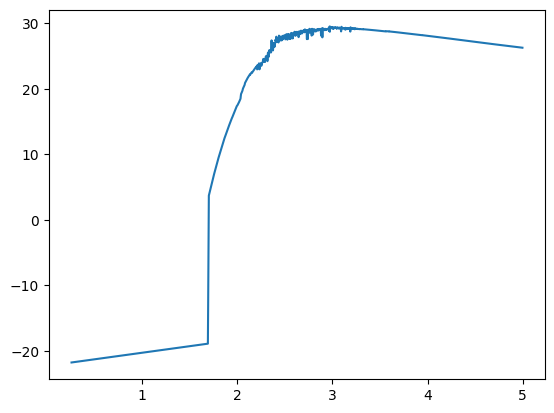

In [7]:
plt.plot(np.log10(sed.lam), np.log10(sed.lnu))
plt.show()

We can also get the luminosity ($L$) or spectral luminosity density per $\AA$ ($L_{\lambda}$): 

In [8]:
print(sed.luminosity)
print(sed.llam)

[0. 0. 0. ... 0. 0. 0.] erg/s
[0. 0. 0. ... 0. 0. 0.] erg/(s*Å)


### Scaling `Sed`s

`Sed` objects can be easily scaled via the `*` operator. For example,

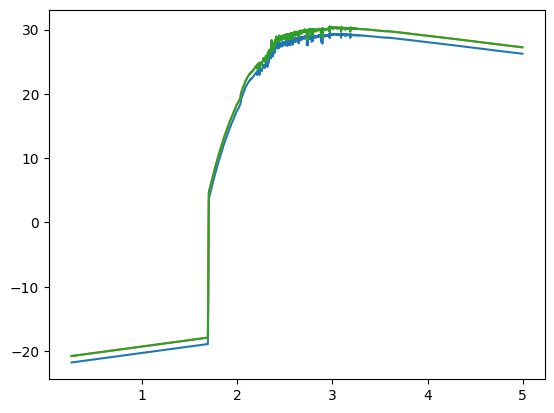

In [9]:
sed3 = sed * 10
sed4 = 10 * sed

plt.plot(np.log10(sed.lam), np.log10(sed.lnu))
plt.plot(np.log10(sed3.lam), np.log10(sed3.lnu))
plt.plot(np.log10(sed4.lam), np.log10(sed4.lnu))
plt.show()

### Methods

#### get_bolometric_luminosity()

This method allows us to calculate the bolometric luminosity of the sed. 

In [10]:
sed.measure_bolometric_luminosity()

unyt_quantity(7.01614831e+44, 'erg/s')

By default the above simply sums up the spectrum. However, we can also integrate the spectrum instead:

In [11]:
sed.measure_bolometric_luminosity(method="quad")

/home/runner/work/synthesizer/synthesizer/src/synthesizer/sed.py:560: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(


unyt_quantity(6.94274574e+44, 'erg/s')

Under-the-hood the above uses a function to get the luminosity at a particular frequency or wavelength:

In [12]:
sed.get_lnu_at_lam(1500 * Angstrom)

unyt_quantity(1.66123407e+29, 'erg/(Hz*s)')

In [13]:
sed.get_lnu_at_nu(1e14 * Hz)

unyt_quantity(1.5576907e+27, 'erg/(Hz*s)')

In [14]:
sed.measure_window_luminosity((1400.0 * Angstrom, 1600.0 * Angstrom))

unyt_quantity(4.04806185e+43, 'erg/s')

In [15]:
sed.measure_window_luminosity((0.14 * um, 0.16 * um))

unyt_quantity(4.04806185e+43, 'erg/s')

In [16]:
sed.measure_window_lnu((1400.0 * Angstrom, 1600.0 * Angstrom))

unyt_quantity(1.5142883e+29, 'erg/(Hz*s)')

In [17]:
sed.measure_window_lnu(
    (1400.0 * Angstrom, 1600.0 * Angstrom), method="average"
)

unyt_quantity(1.51428348e+29, 'erg/(Hz*s)')

In [18]:
sed.measure_window_lnu((1400, 1600) * Angstrom, method="quad")

/home/runner/work/synthesizer/synthesizer/src/synthesizer/sed.py:732: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(func, *lims)[0] / integrate.quad(inv, *lims)[0]


unyt_quantity(1.51222303e+29, 'erg/(Hz*s)')

We can also measure a spectral break by providing two windows, e.g.

In [19]:
sed.measure_break((3400, 3600) * Angstrom, (4150, 4250) * Angstrom)

unyt_quantity(0.85569664, '(dimensionless)')

There are also a few in-built break methods, e.g. `measure_Balmer_break()`

In [20]:
sed.measure_balmer_break()

unyt_quantity(0.85569664, '(dimensionless)')

In [21]:
sed.measure_d4000()

unyt_quantity(0.90143359, '(dimensionless)')

We can also measure absorption line indices:

In [22]:
sed.measure_index(
    (1500, 1600) * Angstrom, (1400, 1500) * Angstrom, (1600, 1700) * Angstrom
)

unyt_quantity(5.80884398, 'Å')

We can also measure the UV spectral slope $\beta$:

In [23]:
sed.measure_beta()

-2.947290162657863

By default this uses a single window and fits the spectrum by a power-law. However, we can also specify two windows as below, in which case the luminosity in each window is calcualted and used to infer a slope:

In [24]:
sed.measure_beta(window=(1250, 1750, 2250, 2750))

-2.9533621846623594

We can also measure ionising photon production rates for a particular ionisation energy:

In [25]:
sed.calculate_ionising_photon_production_rate(
    ionisation_energy=13.6 * eV, limit=1000
)

/home/runner/work/synthesizer/synthesizer/src/synthesizer/sed.py:1304: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(


9.821368035342914e+54

## Observed frame SED

To do this we need to provide a cosmology, using an `astropy.cosmology` object, a redshift $z$, and optionally an IGM absorption model.

In [26]:
from astropy.cosmology import Planck18 as cosmo

z = 10.0  # redshift
sed.get_fnu(cosmo, z, igm=Madau96)  # generate observed frame spectra

unyt_array([0., 0., 0., ..., 0., 0., 0.], 'nJy')

## Photometry

Once we have computed the observed frame SED there is a method on an `Sed` object that allows us to calculate observed photometry (the same is of course true for rest frame photometry). However, first we need to instantiate a `FilterCollection` object.

In [27]:
filter_codes = [
    f"JWST/NIRCam.{f}"
    for f in [
        "F070W",
        "F090W",
        "F115W",
        "F150W",
        "F200W",
        "F277W",
        "F356W",
        "F444W",
    ]
]  # define a list of filter codes
fc = FilterCollection(filter_codes, new_lam=grid.lam)

In [28]:
# Measure observed photometry
fluxes = sed.get_photo_fluxes(fc)
print(fluxes)

-------------------------------------------------------------------
|                        PHOTOMETRY (FLUX)                        |
|------------------------------------|----------------------------|
| JWST/NIRCam.F070W (λ = 7.04e+03 Å) | -0.00e+00 erg/(Hz*cm**2*s) |
|------------------------------------|----------------------------|
| JWST/NIRCam.F090W (λ = 9.02e+03 Å) | 3.51e-12 erg/(Hz*cm**2*s)  |
|------------------------------------|----------------------------|
| JWST/NIRCam.F115W (λ = 1.15e+04 Å) | 7.62e-03 erg/(Hz*cm**2*s)  |
|------------------------------------|----------------------------|
| JWST/NIRCam.F150W (λ = 1.50e+04 Å) | 1.30e+02 erg/(Hz*cm**2*s)  |
|------------------------------------|----------------------------|
| JWST/NIRCam.F200W (λ = 1.99e+04 Å) | 1.10e+02 erg/(Hz*cm**2*s)  |
|------------------------------------|----------------------------|
| JWST/NIRCam.F277W (λ = 2.76e+04 Å) | 7.76e+01 erg/(Hz*cm**2*s)  |
|------------------------------------|----------

## Multiple SEDs

The `Sed` object can actually hold an array of seds and the methods should all work fine.

Let's create an `Sed` object with two seds:

In [29]:
sed2 = Sed(sed.lam, np.array([sed.lnu, sed.lnu * 2]))

In [30]:
sed2.measure_window_lnu((1400, 1600) * Angstrom)

unyt_array([1.5142883e+29, 3.0285766e+29], 'erg/(Hz*s)')

In [31]:
sed2.measure_window_lnu((1400, 1600) * Angstrom, method="average")

unyt_array([1.51428348e+29, 3.02856696e+29], 'erg/(Hz*s)')

In [32]:
sed2.measure_beta()

array([-2.94729016, -2.94729016])

In [33]:
sed2.measure_beta(window=(1250, 1750, 2250, 2750))

array([-2.95336218, -2.95336218])

In [34]:
sed2.measure_balmer_break()

unyt_array([0.85569664, 0.85569664], '(dimensionless)')

In [35]:
sed2.measure_index(
    (1500, 1600) * Angstrom, (1400, 1500) * Angstrom, (1600, 1700) * Angstrom
)

unyt_array([5.80884398, 5.80884398], 'Å')

### Combining SEDs

`Sed`s can be combined either via concatenation to produce a single `Sed` holding multiple spectra from the combined `Sed`s, or by addition to add the spectra contained in two `Sed`s. 

To concatenate spectra we can use `Sed.concat()`.

In [36]:
print("Shapes before:", sed._lnu.shape, sed2._lnu.shape)
sed3 = sed2.concat(sed)
print("Combined shape:", sed3._lnu.shape)

Shapes before: (8228,) (2, 8228)
Combined shape: (3, 8228)


`Sed.concat` can take an arbitrary number of `Sed` objects to combine.

In [37]:
sed4 = sed2.concat(sed, sed2, sed3)
print("Combined shape:", sed4._lnu.shape)

Combined shape: (8, 8228)


If we want to add the spectra of 2 `Sed` objects we simply apply the `+` operator. However, unlike `concat`, this will only work for `Sed`s with identical shapes.

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


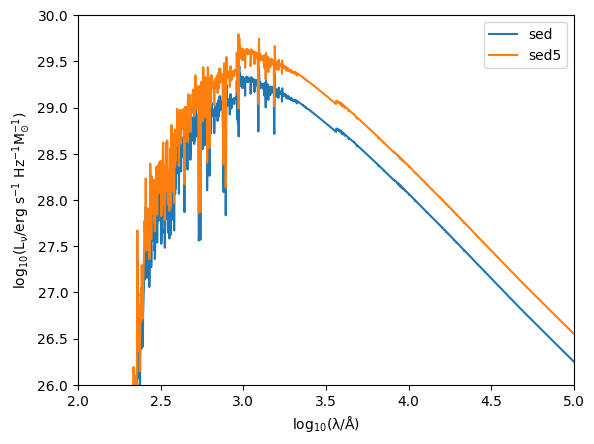

In [38]:
sed5 = sed + sed
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="sed")
plt.plot(np.log10(sed5.lam), np.log10(sed5.lnu), label="sed5")
plt.ylim(26, 30)
plt.xlim(2, 5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

## Resampling SEDs

The `Sed` includes a method to resample an sed, e.g. to lower-resolution or to match observations.


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



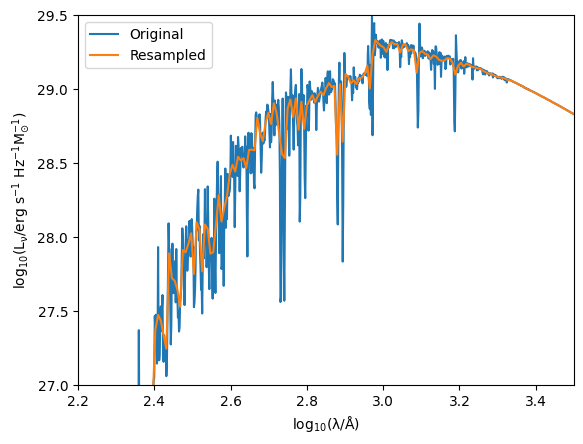

In [39]:
sed6 = sed.get_resampled_sed(5)
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="Original")
plt.plot(np.log10(sed6.lam), np.log10(sed6.lnu), label="Resampled")
plt.xlim(2.2, 3.5)
plt.ylim(27.0, 29.5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

In [40]:
print(
    sed.measure_bolometric_luminosity() / sed3.measure_bolometric_luminosity()
)

[1.  0.5 1. ] dimensionless


## Applying attenuation

To apply attenuation to an `Sed` you can use the `apply_attenuation` method and pass the optical depth. An instance of a dust curve can also be provided but this defaults to a power law with slope = 1 (`synthesizer.dust.attenuation.PowerLaw(slope=1)`).

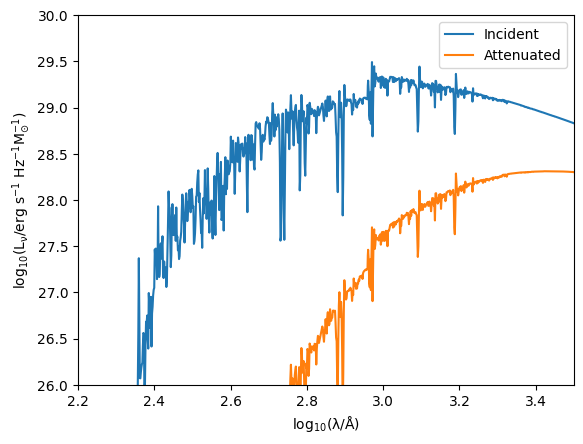

In [41]:
sed4_att = sed4.apply_attenuation(tau_v=0.7)

plt.plot(np.log10(sed4.lam), np.log10(sed4.lnu[0, :]), label="Incident")
plt.plot(
    np.log10(sed4_att.lam), np.log10(sed4_att.lnu[0, :]), label="Attenuated"
)
plt.xlim(2.2, 3.5)
plt.ylim(26.0, 30.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

The only other argument `apply_attenuation` can take is a mask for applying attenuation to speicifc spectra in an `Sed` with multiple spectra (like an `Sed` containing the spectra for multiple particles for instance.)

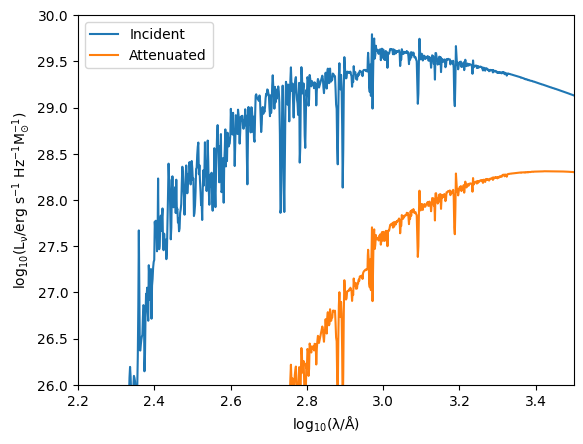

In [42]:
sed7_att = sed4.apply_attenuation(
    tau_v=0.7, mask=np.array([1, 0, 0, 0, 0, 0, 0, 0], dtype=bool)
)

plt.plot(np.log10(sed7_att.lam), np.log10(sed4.lnu[1, :]), label="Incident")
plt.plot(
    np.log10(sed7_att.lam), np.log10(sed7_att.lnu[0, :]), label="Attenuated"
)
plt.xlim(2.2, 3.5)
plt.ylim(26.0, 30.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

## Calculating transmission

If you have an attenuated SED, a natural quantity to calculate is the extinction of that spectra ($A$). This can be done either at the wavelengths of the `Sed`, an arbitrary wavelength/wavelength array, or at commonly used values (1500 and 5500 angstrom) using functions available in the `sed` module. Note that these functions return the extinction/attenuation in magnitudes. Below is a demonstration.

In [43]:
from unyt import um, angstrom
from synthesizer.sed import (
    get_attenuation,
    get_attenuation_at_lam,
    get_attenuation_at_1500,
    get_attenuation_at_5500,
)

# Get an intrinsic spectra
grid_point = grid.get_grid_point((7, 0.01))
int_sed = grid.get_spectra(grid_point, spectra_id="incident")

# Get the attenuated spectra
att_sed = int_sed.apply_attenuation(tau_v=0.7)

# Get attenuation at sed.lam
attenuation = get_attenuation(int_sed, att_sed)
print(attenuation[~np.isnan(attenuation)])

# Get attenuation at 5 microns
att_at_5 = get_attenuation_at_lam(5 * um, int_sed, att_sed)
print(att_at_5)

# Get attenuation at an arbitrary range of wavelengths
att_at_range = get_attenuation_at_lam(
    np.linspace(5000, 10000, 5) * angstrom, int_sed, att_sed
)
print(att_at_range)

# Get attenuation at 1500 angstrom
att_at_1500 = get_attenuation_at_1500(int_sed, att_sed)
print(att_at_1500)

# Get attenuation at 5500 angstrom
att_at_5500 = get_attenuation_at_5500(int_sed, att_sed)
print(att_at_5500)

[       inf        inf        inf ... 0.04221877 0.04207831 0.04193828]
0.08360170415641599
[0.83601817 0.66881427 0.5573455  0.47772428 0.41800898]
2.786725867509981
0.7600168668767144


/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1938: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
